In [1]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' 
# U-Net modelini oluşturalım
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    
    return model


In [2]:
import os
import numpy as np
#from custom_datagen import imageLoader
#import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random

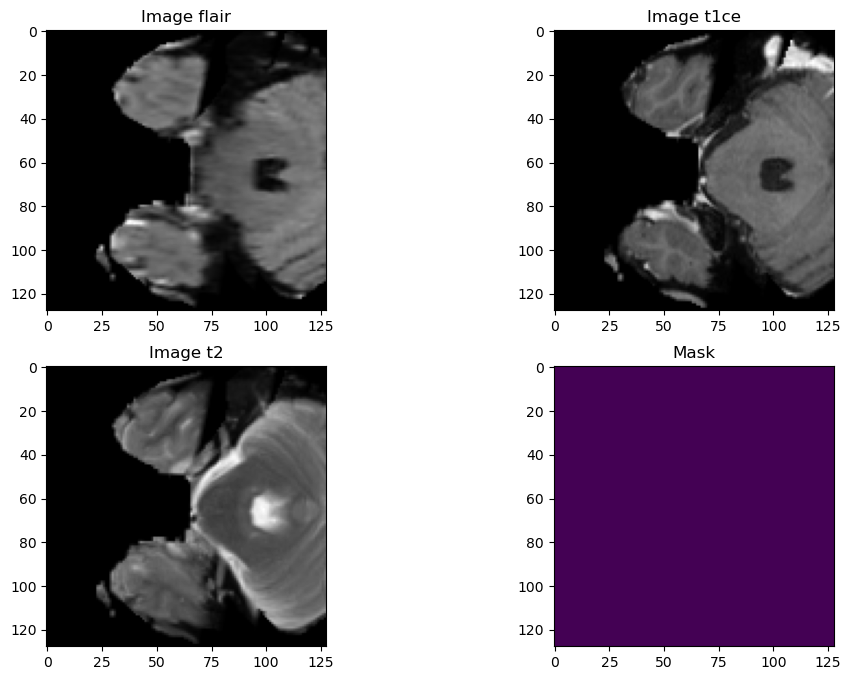

In [3]:
train_img_dir = "D:/archive/BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "D:/archive/BraTS2020_TrainingData/input_data_128/train/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


In [4]:
import pandas as pd
columns = ['0','1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('D:/archive/BraTS2020_TrainingData/input_data_128/train/masks/*.npy'))
for img in range(len(train_mask_list)):
    print(img)
    temp_image=np.load(train_mask_list[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)
    
    df = df.append(conts_dict, ignore_index=True)

# Her bir label ('0', '1', '2', '3') için toplam sayıları hesaplayın.
label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['2'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4

# Sınıf ağırlıklarını hesaplama: n_samples / (n_classes * n_samples_for_class)
# Herhangi bir label sayısının sıfır olduğunu kontrol edin ve bu durumu ele almak için ağırlığı varsayılan olarak 1 olarak ayarlayın.
wt0 = round((total_labels / (n_classes * label_0)), 2) if label_0 > 0 else 1.0
wt1 = round((total_labels / (n_classes * label_1)), 2) if label_1 > 0 else 1.0
wt2 = round((total_labels / (n_classes * label_2)), 2) if label_2 > 0 else 1.0
wt3 = round((total_labels / (n_classes * label_3)), 2) if label_3 > 0 else 1.0



train_img_dir = "D:/archive/BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "D:/archive/BraTS2020_TrainingData/input_data_128/train/masks/"

val_img_dir = "D:/archive/BraTS2020_TrainingData/input_data_128/val/images/"
val_mask_dir = "D:/archive/BraTS2020_TrainingData/input_data_128/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

0


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


1


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


2


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


3


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


4


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


5


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


6


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


7


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


8


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


9


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


10


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


11


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


12


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


13


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


14


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


15


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


16


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


17


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


18


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


19


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


20


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


21


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


22


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


23


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


24


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


25


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


26


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


27


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


28


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


29


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


30


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


31


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


32
33


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


34


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


35


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


36


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


37


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


38


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


39


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


40


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


41


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


42


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


43


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


44


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


45


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


46


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


47


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


48


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


49


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


50


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


51


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


52


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


53


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


54


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


55


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


56


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


57


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


58


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


59


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


60


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


61


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


62


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


63


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


64


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


65


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


66


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


67


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


68


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


69


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


70


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


71


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


72


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


73


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


74


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


75


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


76


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


77


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


78


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


79


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


80


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


81


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


82


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


83


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


84


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


85


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


86


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


87


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


88


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


89


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


90


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


91


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


92


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


93


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


94


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


95


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


96


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


97


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


98


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


99


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


100


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


101


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


102


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


103


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


104


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


105


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


106


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


107


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


108


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


109


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


110


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


111


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


112


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


113


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


114


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


115


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


116


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


117


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


118


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


119


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


120


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


121


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


122


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


123


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


124


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


125


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


126


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


127


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


128


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


129


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


130


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


131


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


132


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


133


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


134


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


135


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


136


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


137


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


138


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


139


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


140


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


141


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


142


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


143


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


144


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


145


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


146


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


147


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


148


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


149


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


150


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


151


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


152


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


153


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


154


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


155


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


156


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


157


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


158


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


159


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


160


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


161


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


162


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


163


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


164


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


165


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


166


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


167


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


168


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


169


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


170


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


171


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


172


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


173


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


174


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


175


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


176


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


177


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


178


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


179


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


180


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


181


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


182


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


183


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


184


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


185


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


186


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


187


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


188


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


189


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


190


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


191


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


192


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


193


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


194


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


195


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


196


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


197


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


198


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


199


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


200


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


201


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


202


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


203


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


204


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


205


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


206


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


207


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


208


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


209


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


210


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


211


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


212


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


213


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


214


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


215


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


216


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


217


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


218


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


219


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


220


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


221


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


222


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


223


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


224


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


225


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


226


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


227


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


228


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


229


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


230


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


231


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


232


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


233


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


234


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


235


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


236


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


237


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


238


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


239


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


240


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


241


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


242


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


243


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


244


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


245


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


246


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


247


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


248


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


249


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


250


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


251


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


252


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


253


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


254


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


255


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


256


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


257


C:\Users\sibel\AppData\Local\Temp\ipykernel_7736\1970869980.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


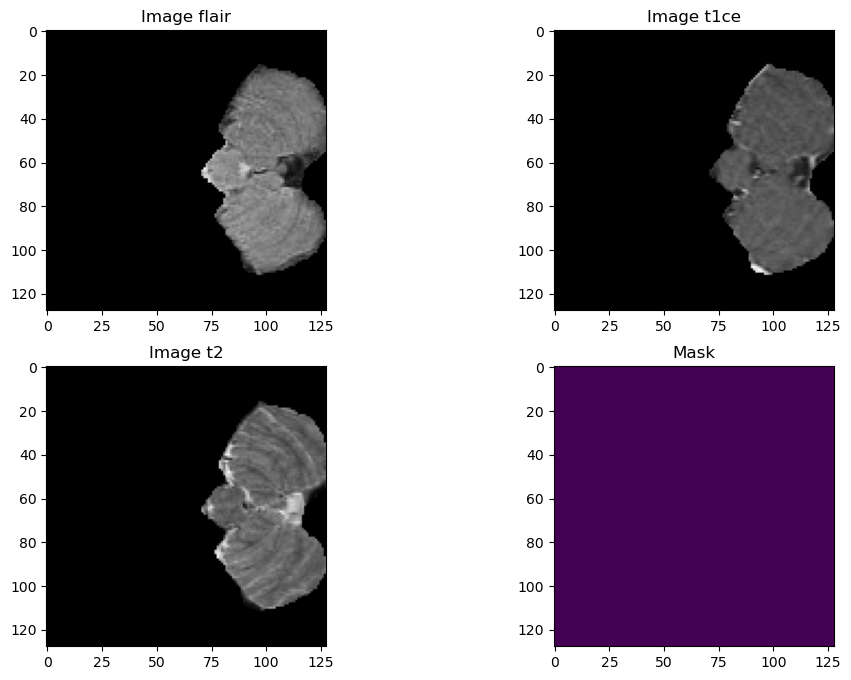

In [5]:
%run custom_datagen.ipynb

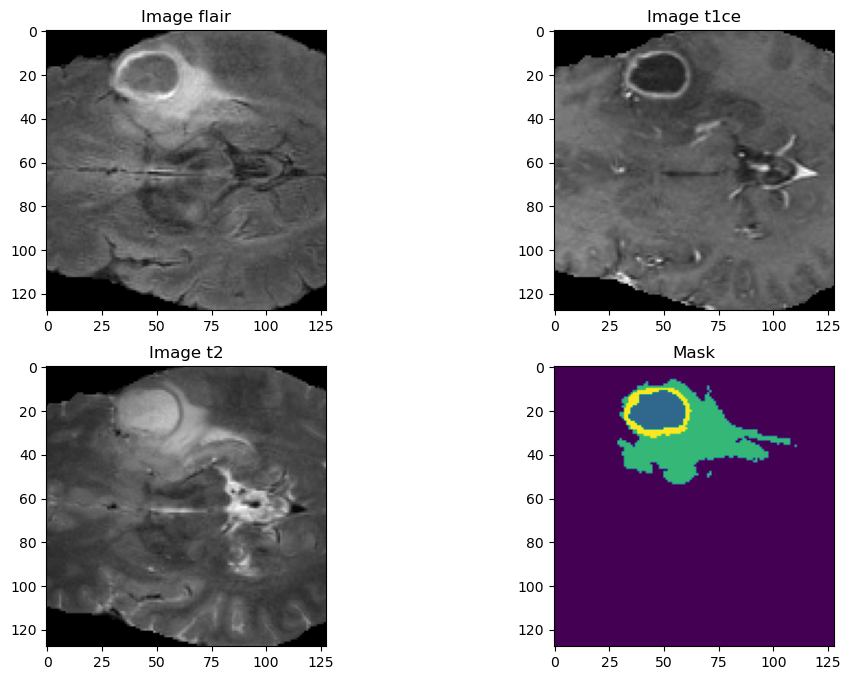

In [6]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


In [7]:
""""
import numpy as np
import tensorflow as tf
import segmentation_models_3D as sm

# Ağırlık değerlerini tanımlayın
wt0, wt1, wt2, wt3 = 0.25, 0.25, 0.25, 0.25

# Dice loss'u oluşturun
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))

# Focal loss'u oluşturun
focal_loss = sm.losses.CategoricalFocalLoss()

# Toplam kaybı hesaplayın
total_loss = dice_loss + (1 * focal_loss)

# Metrikleri tanımlayın
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

# Öğrenme oranını tanımlayın
LR = 0.0001

# Optimizasyon işlemcisini tanımlayın (Adam optimizasyonu kullanıyoruz)
optim = tf.keras.optimizers.Adam(learning_rate=LR)
"""

'"\nimport numpy as np\nimport tensorflow as tf\nimport segmentation_models_3D as sm\n\n# Ağırlık değerlerini tanımlayın\nwt0, wt1, wt2, wt3 = 0.25, 0.25, 0.25, 0.25\n\n# Dice loss\'u oluşturun\ndice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))\n\n# Focal loss\'u oluşturun\nfocal_loss = sm.losses.CategoricalFocalLoss()\n\n# Toplam kaybı hesaplayın\ntotal_loss = dice_loss + (1 * focal_loss)\n\n# Metrikleri tanımlayın\nmetrics = [\'accuracy\', sm.metrics.IOUScore(threshold=0.5)]\n\n# Öğrenme oranını tanımlayın\nLR = 0.0001\n\n# Optimizasyon işlemcisini tanımlayın (Adam optimizasyonu kullanıyoruz)\noptim = tf.keras.optimizers.Adam(learning_rate=LR)\n'

In [8]:
import tensorflow as tf
# Öğrenme oranını tanımlayın
LR = 0.0001

# IoU (Intersection over Union) metriği tanımlama
def iou_score(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)
# Optimizasyon işlemcisini tanımlayın (Adam optimizasyonu kullanıyoruz)

optim = tf.keras.optimizers.Adam(learning_rate=LR)

loss_function = 'categorical_crossentropy'

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 128, 3)]   0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 128, 128, 128, 16)    1312      ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 128, 16)    0         ['conv3d[0][0]']              
                                                                                                  
 conv3d_1 (Conv3D)           (None, 128, 128, 128, 16)    6928      ['dropout[0][0]']             
                                                                                              

 conv3d_transpose_3 (Conv3D  (None, 128, 128, 128, 16)    4112      ['conv3d_15[0][0]']           
 Transpose)                                                                                       
                                                                                                  
 concatenate_3 (Concatenate  (None, 128, 128, 128, 32)    0         ['conv3d_transpose_3[0][0]',  
 )                                                                   'conv3d_1[0][0]']            
                                                                                                  
 conv3d_16 (Conv3D)          (None, 128, 128, 128, 16)    13840     ['concatenate_3[0][0]']       
                                                                                                  
 dropout_8 (Dropout)         (None, 128, 128, 128, 16)    0         ['conv3d_16[0][0]']           
                                                                                                  
 conv3d_17

In [ ]:
model.compile(optimizer = optim, loss =  loss_function, metrics=[iou_score])
print(model.summary())

print(model.input_shape)
print(model.output_shape)

history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=1b00,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

model.save('brats_3d.hdf5')

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 128, 3)]   0         []                            
                                                                                                  
 conv3d_76 (Conv3D)          (None, 128, 128, 128, 16)    1312      ['input_5[0][0]']             
                                                                                                  
 dropout_36 (Dropout)        (None, 128, 128, 128, 16)    0         ['conv3d_76[0][0]']           
                                                                                                  
 conv3d_77 (Conv3D)          (None, 128, 128, 128, 16)    6928      ['dropout_36[0][0]']          
                                                                                            

 conv3d_transpose_19 (Conv3  (None, 128, 128, 128, 16)    4112      ['conv3d_91[0][0]']           
 DTranspose)                                                                                      
                                                                                                  
 concatenate_19 (Concatenat  (None, 128, 128, 128, 32)    0         ['conv3d_transpose_19[0][0]', 
 e)                                                                  'conv3d_77[0][0]']           
                                                                                                  
 conv3d_92 (Conv3D)          (None, 128, 128, 128, 16)    13840     ['concatenate_19[0][0]']      
                                                                                                  
 dropout_44 (Dropout)        (None, 128, 128, 128, 16)    0         ['conv3d_92[0][0]']           
                                                                                                  
 conv3d_93

In [ ]:
# Eğitim ve doğrulama IoU ve kaybını her epokta çiz
kayip = history.history['loss']
val_kayip = history.history['val_loss']
epoklar = range(1, len(kayip) + 1)
plt.plot(epoklar, kayip, 'y', label='Eğitim kaybı')
plt.plot(epoklar, val_kayip, 'r', label='Doğrulama kaybı')
plt.title('Eğitim ve doğrulama kaybı')
plt.xlabel('Epoklar')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

dogruluk = history.history['accuracy']
val_dogruluk = history.history['val_accuracy']

plt.plot(epoklar, dogruluk, 'y', label='Eğitim doğruluk')
plt.plot(epoklar, val_dogruluk, 'r', label='Doğrulama doğruluk')
plt.title('Eğitim ve doğrulama doğruluk')
plt.xlabel('Epoklar')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

# Modeli tahmin veya eğitime devam etmek için yükleyin

# Eğitime devam etmek için....
# Aşağıdaki hata verir: Unknown loss function: dice_loss_plus_1focal_loss
# Bu, modelin kayıp işlevi ve metriklerini kaydetmemesinden kaynaklanır. Bu nedenle eğitime devam etmek için bunları özel nesneler olarak sağlamamız gerekir.
my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5')

# Kayıp işlevini özel nesne olarak ekleyelim... ancak aşağıdaki hata fırlatılır...
# Unknown metric function: iou_score
my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss})

# Şimdi, eğitim sırasını başlatmak için kullandığımız iou_score işlevini ekleyelim
my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

# Şimdi, eğitim işlemine devam etmek için her şey hazır.
history2=my_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=1,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

# Tahminler için modeli yükleme işlemi sırasında modeli derlemeniz gerekmez, bu nedenle...
my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5', 
                      compile=False)

# Test veri kümesinden birkaç resmi tahmin etme, birer birer
# Denemek için resimler:
resim_numarası = 82

test_resim = np.load("BraTS2020_TrainingData/input_data_128/val/images/image_"+str(resim_numarası)+".npy")

test_maskesi = np.load("BraTS2020_TrainingData/input_data_128/val/masks/mask_"+str(resim_numarası)+".npy")
test_maskesi_argmax=np.argmax(test_maskesi, axis=3)

test_resim_input = np.expand_dims(test_resim, axis=0)
test_tahmini = my_model.predict(test_resim_input)
test_tahmini_argmax=np.argmax(test_tahmini, axis=4)[0,:,:,:]


# Tekil kesitleri test tahminlerini doğrulamak için çizin
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_aax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Test Resmi')
plt.imshow(test_resim[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Test Etiketi')
plt.imshow(test_maskesi_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Test Resmi Üzerine Tahmin')
plt.imshow(test_tahmini_argmax[:,:, n_slice])
plt.show()

In [ ]:
# Eğitim ve doğrulama IoU ve kaybını her epoch da çiz
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


from keras.models import load_model

# Modeli tahmin veya eğitime devam etmek için yükleyin

# Eğitime devam etmek için....
# Aşağıdaki hata verir: Unknown loss function: dice_loss_plus_1focal_loss
# Bu, modelin kayıp işlevi ve metriklerini kaydetmemesinden kaynaklanır. Bu nedenle eğitime devam etmek 
#için bunları özel nesneler olarak sağlamamız gerekir.
my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5')

# Kayıp işlevini özel nesne olarak ekleyelim... ancak aşağıdaki hata fırlatılır...
# Unknown metric function: iou_score
my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss})


# Şimdi, eğitim sırasını başlatmak için kullandığımız iou_score işlevini ekleyelim
my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,

# Test veri kümesinden birkaç resmi tahmin etme, birer birer
# Denemek için resimler:
history2=my_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=1,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )


# Tahminler için modeli yükleme işlemi sırasında modeli derlemeniz gerekmez, bu nedenle...
my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5', 
                      compile=False)



from keras.metrics import MeanIoU

batch_size=8 
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)


test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


img_num = 82

test_img = np.load("BraTS2020_TrainingData/input_data_128/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("BraTS2020_TrainingData/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))


from matplotlib import pyplot as plt
import random


n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()
